In [108]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
import regex as re
import json
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mauib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [109]:
STOPWORDS = set(stopwords.words('english'))
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
USERNAME_RE = re.compile('@[^\s]+')
HASHTAG_RE = re.compile('#[^\s]+')

VOCAB_SIZE = 10000
TEXT_MAX_LEN = 200
TRUNCATING_TYPE = PADDING_TYPE = 'post'
OOV_TOK = '<OOV>'

In [110]:
# data pre processing

texts = []
labels = []

df = pd.read_csv('DATASET.csv', names=['label', 'text'])
df = df.sample(frac=1).reset_index(drop=True)

for index, row in df.iterrows():
    if 'http' in str(row['text']): continue

    labels.append(row['label'])
    
    txt = str(row['text']).lower()
    txt = USERNAME_RE.sub('', txt)
    txt = REPLACE_BY_SPACE_RE.sub(' ', txt)
    txt = BAD_SYMBOLS_RE.sub(' ', txt)
    txt = ' '.join(word for word in txt.split() if word not in STOPWORDS)

    texts.append(txt)

print(len(texts), len(labels))

32465 32465


In [111]:
# data splitting
TRAIN_SIZE = int(len(texts) * .8)

training_labels = labels[0:TRAIN_SIZE]
training_texts = texts[0:TRAIN_SIZE]

testing_labels = labels[TRAIN_SIZE:]
testing_texts = texts[TRAIN_SIZE:]

print(len(training_labels), len(training_texts))
print(len(testing_labels), len(testing_texts))

25972 25972
6493 6493


In [124]:
# tokenizing texts
text_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOK, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n')
text_tokenizer.fit_on_texts(testing_texts)

training_texts_sequence = text_tokenizer.texts_to_sequences(training_texts)
training_texts_padded = pad_sequences(training_texts_sequence, maxlen=TEXT_MAX_LEN, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)

testing_texts_sequence = text_tokenizer.texts_to_sequences(testing_texts)
testing_texts_padded = pad_sequences(testing_texts_sequence, maxlen=TEXT_MAX_LEN, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)

# tokenizing labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_labels_sequence = np.array(label_tokenizer.texts_to_sequences(training_labels))
testing_labels_sequence = np.array(label_tokenizer.texts_to_sequences(testing_labels))

print(len(training_labels_sequence), len(training_texts_padded))
print(len(testing_labels_sequence), len(testing_texts_padded))

25972 25972
6493 6493


In [113]:
# creating the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(text_tokenizer.word_index), 64, input_length=TEXT_MAX_LEN),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           876224    
                                                                 
 dropout (Dropout)           (None, 200, 64)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                        

In [114]:
# training model
num_epochs = 1
history = model.fit(training_texts_padded, training_labels_sequence, epochs=num_epochs, validation_data=(testing_texts_padded, testing_labels_sequence), verbose=1)
test_loss, test_accuracy = model.evaluate(testing_texts_padded, testing_labels_sequence)

print(f'Loss: {test_loss}, Accuracy: {test_accuracy}')

203/203 [==============================] - 10s 51ms/step - loss: 0.5925 - accuracy: 0.7684
Loss: 0.5924952626228333, Accuracy: 0.7683659195899963


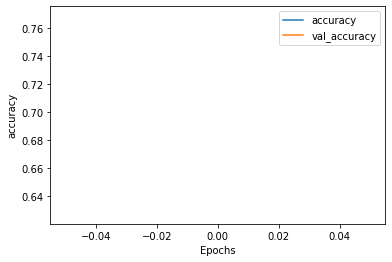

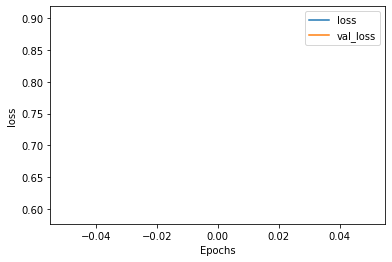

In [115]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [127]:
# saving model
model.save('model.h5')

# saving vocabs
json.dump(text_tokenizer.word_index, open('vocabs.txt', 'w'))

tf.keras.backend.clear_session()

In [125]:
# testing to get a prediction
entry = ['you are a piece of shit']
entry_sequence = text_tokenizer.texts_to_sequences(entry)
entry_padded = pad_sequences(entry_sequence, maxlen=TEXT_MAX_LEN, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)
print(entry_padded)
prediction = model.predict(entry_padded)
labels = ['suicide', 'cyberbullying', 'neutral', 'nsfw']
print(prediction, labels[np.argmax(prediction)-1])

[[   1    1 8442  366    1   42    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   